In [1]:
from dataclasses import asdict, dataclass

import seaborn as sns
import torch
import wandb
from contextual_distros import ContextDataset, ContextualGMM
from dvi_process import DIS, CMCD
from matplotlib import pyplot as plt
from score_function import ScoreFunction
from torch.utils.data import DataLoader
from train import train

In [2]:
import torch_directml

device = torch.device("cpu") 
# device  = torch_directml.device()

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 1
    z_dim = 1
    h_dim = 32
    num_layers = 3
    non_linearity = "SiLU"
    learning_rate = 3e-3 # 3e-3
    size = 4096
    batch_size = 4096

config = Config()

In [4]:
dataset = ContextDataset(size=config.size, c_dim=config.c_dim, max_context_size=1, sampling_factor=1, variably_sized_context=False)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
score_function = ScoreFunction(
    c_dim=config.c_dim, 
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps,
    variably_sized_context=False
)

dvi_process = DIS(
    device=device, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    score_function=score_function
).to(device)

In [6]:
target_constructor = ContextualGMM

In [7]:
wandb_logging = False
if wandb_logging:
    wandb.init(project="dvi-1d", config=asdict(config))

In [8]:
num_epochs = 1000
optimizer = torch.optim.Adam(dvi_process.parameters(), lr=config.learning_rate)

In [9]:
losses = train(
    dvi_process, 
    device,
    num_epochs, 
    dataloader, 
    target_constructor,
    optimizer,  
    wandb_logging=wandb_logging
)

  0%|          | 0/1 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'contextual_distros.ContextualGMM'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  9.97it/s, epoch=999, loss=18.3]


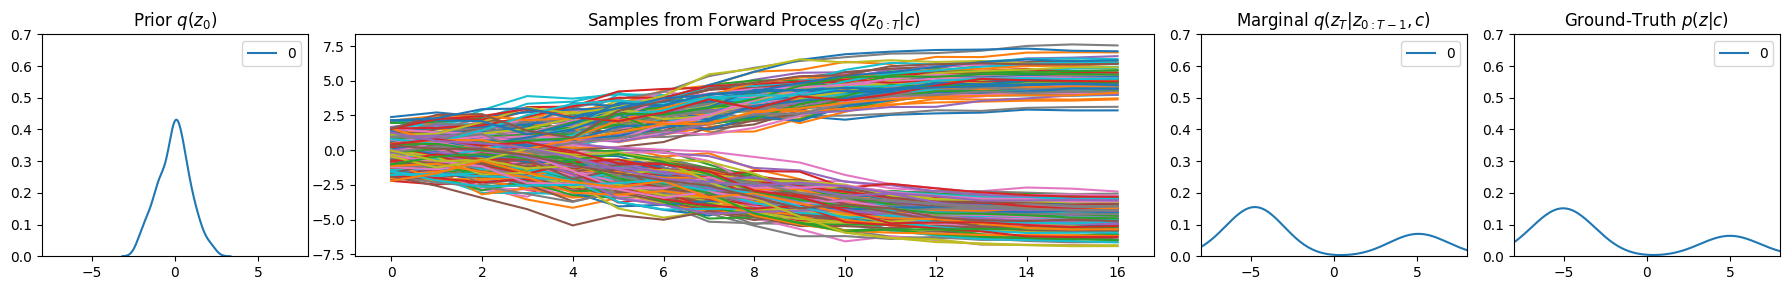

In [10]:
num_samples = 256

context = torch.zeros((num_samples, 1, config.c_dim), device=device)

p_z_T = target_constructor(context)

z_target_samples = p_z_T.sample()

dvi_process.eval()

# with torch.no_grad():
_, z_samples = dvi_process.run_chain(p_z_T, context.to(device))

z_0_samples = z_samples[0].detach().cpu().numpy()
z_T_samples = z_samples[-1].detach().cpu().numpy()

z_trajectories = [[z[i, :].detach().cpu().numpy() for z in z_samples] for i in range(num_samples)]

fig, ax = plt.subplots(1, 4, figsize=(18, 3), gridspec_kw={'width_ratios': [1, 3, 1, 1]})

sns.kdeplot(z_0_samples, ax=ax[0])
ax[0].set_title("Prior $q(z_0)$")
ax[0].set_ylabel(None)
ax[0].set_xlim(-8, 8)
ax[0].set_ylim(0, 0.7)

for i in range(num_samples):
    ax[1].plot(z_trajectories[i])
ax[1].set_title("Samples from Forward Process $q(z_{0:T}|c)$")

sns.kdeplot(z_T_samples, ax=ax[2])
ax[2].set_title("Marginal $q(z_T|z_{0:T-1},c)$")
ax[2].set_ylabel(None)
ax[2].set_xlim(-8, 8)
ax[2].set_ylim(0, 0.7)

sns.kdeplot(z_target_samples, ax=ax[3])
ax[3].set_title("Ground-Truth $p(z|c)$")
ax[3].set_ylabel(None)
ax[3].set_xlim(-8, 8)
ax[3].set_ylim(0, 0.7)

plt.tight_layout()
plt.show()